In [2]:
# Import modelflow

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#### %matplotlib inline

In [4]:
import matplotlib.pyplot as plt

In [5]:
from ipywidgets import interact,Dropdown,Checkbox
from IPython.display import display, clear_output,Latex, Markdown
import pandas as pd
from tqdm.auto import tqdm 


import modeljupyter as mj
from modelvis import waterplot

from modelinvert import targets_instruments
from modelclass import model
model.widescreen()

In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;
}

<IPython.core.display.Javascript object>

In [7]:
# Load model and data, and run 

if not 'masia' in locals():
    print('Load model')
    masia,baseline = model.modelload('Asia.pcim',run=1,silent=1)
from inject import inject
inject(masia)    

Load model


In [8]:
co2_input_var = [var for var in masia.totgraph.predecessors('WLD_CO2') if var.endswith('CO2')]
co2_input_var_asean = [var for var in masia.totgraph.predecessors('WLD_CO2') if var.endswith('CO2') and  var.split('_')[0] in masia.countries_ASEAN ]

In [9]:
co2_var_all = masia.vlist('*_CO2')

In [10]:
co2_baseline = baseline.loc[:,co2_input_var].pipe(lambda df:df.rename(columns={c : masia.iso_dict.get(cname := c.split('_')[0],cname) for c in df.columns}))
co2_baseline_asean = baseline.loc[:,co2_input_var_asean].pipe(lambda df:df.rename(columns={c : masia.iso_dict.get(cname := c.split('_')[0],cname) for c in df.columns}))

# The impact of carbon tax

In [11]:
# Make experiments 
rate_var =  [f'{country}_GCARBR_A' for country in masia.countries_GCARBR_A]
experiments = list(range(0,360,50))
bars = '{desc}: {percentage:3.0f}%|{bar}|Experiment {n_fmt}/{total_fmt}'
with tqdm(total=len(experiments),desc='Simulating different taxrates',bar_format=bars) as pbar:
    for rate in experiments:
        thisdf = baseline.copy()
        thisdf.loc[2021,rate_var] = thisdf.loc[2021,rate_var] + rate
        masia(thisdf,keep = f'{rate}',keep_variables='*_CO2',progressbar=0)
        pbar.update()


Simulating different taxrates:   0%|          |Experiment 0/8

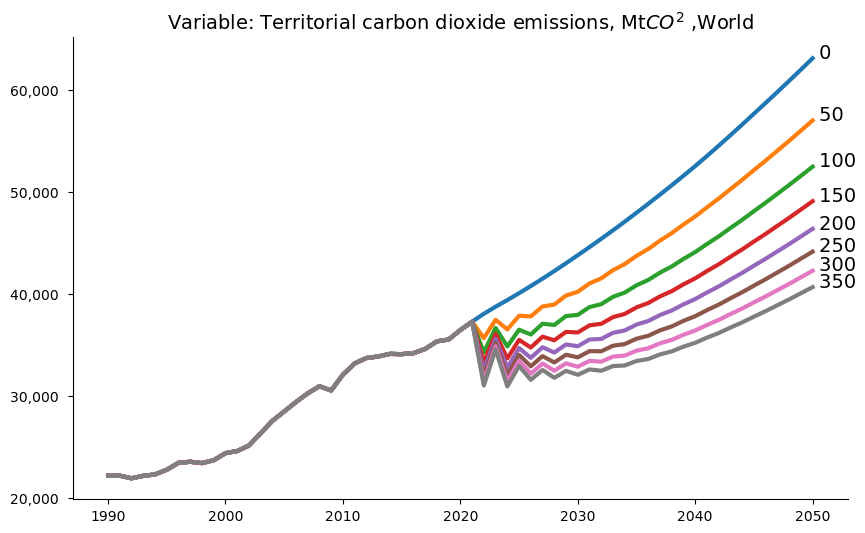

In [12]:
with masia.set_smpl(1990,2050):
    display(masia.keep_plot('wld_co2',legend=0)['WLD_CO2'])

# What happens to the global $CO^2$ emmision in 2050 when taxes are increased 

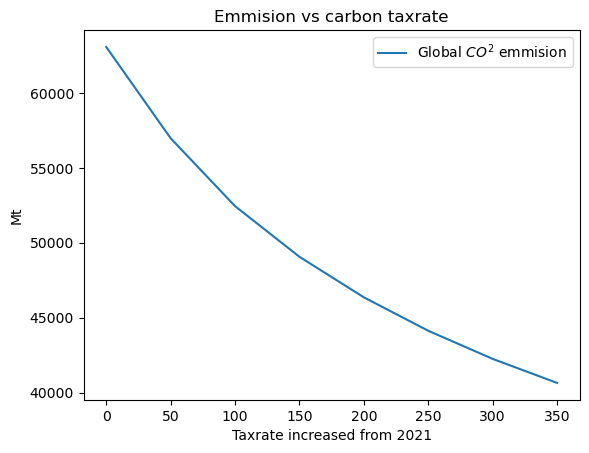

In [13]:
endvalues_ser = pd.Series({rate:df.loc[2050,'WLD_CO2'] for rate,df in masia.keep_solutions.items()})
endvalues = pd.DataFrame(endvalues_ser,columns = ['Global $CO^2$ emmision'])
endvalues.plot(xlabel = 'Taxrate increased from 2021',ylabel = 'Mt',title='Emmision vs carbon taxrate').figure


# The marginal impact of the 50 extra tax in each experiment 

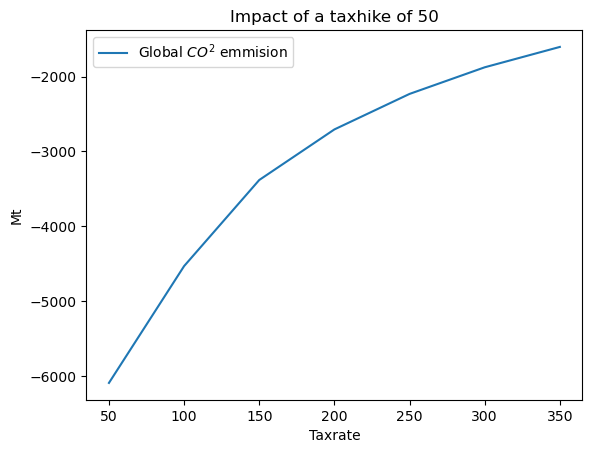

In [14]:
endvalues.diff().plot(xlabel = 'Taxrate',ylabel = 'Mt',title='Impact of a taxhike of 50').figure

In [15]:
plt.clf();

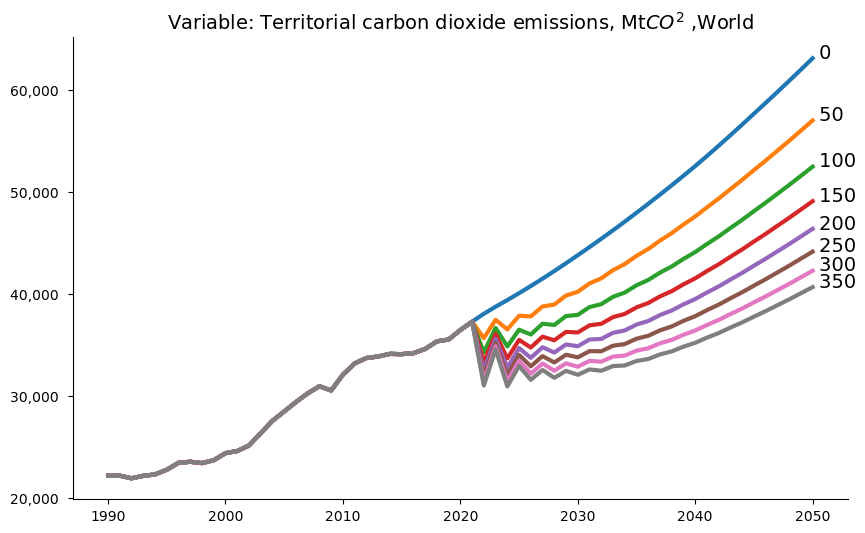

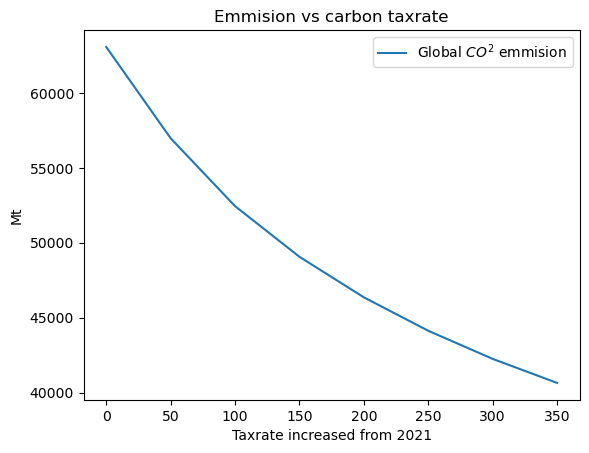

<Figure size 640x480 with 0 Axes>

Output()

In [16]:
with masia.set_smpl(2000,2050):
    masia.keep_viz(pat='WLD_CO2',selectfrom=co2_var_all,use_descriptions=False ,legend=0);